<img src="https://i.imgur.com/mIeeaBD.png">

<img src="https://i.imgur.com/XGJuheO.png">

<img src="https://i.imgur.com/HZEhuHF.png">

# **Hybrid Forecasting with Residuals**
In previous lessons, we used a single algorithm (linear regression) to learn all the components at once. But it's also possible to use one algorithm for some of the components and another algorithm for the rest. This way we can always choose the best algorithm for each component. To do this, we use one algorithm to fit the original series and then the second algorithm to fit the residual series.

In detail, the process is this:

```python:
# 1. Train and predict with first model
model_1.fit(X_train_1, y_train)
y_pred_1 = model_1.predict(X_train)

# 2. Train and predict with second model on residuals
model_2.fit(X_train_2, y_train - y_pred_1)
y_pred_2 = model_2.predict(X_train_2)

# 3. Add to get overall predictions
y_pred = y_pred_1 + y_pred_2
```

We'll usually want to use different feature sets (`X_train_1` and `X_train_2` above) depending on what we want each model to learn. If we use the first model to learn the trend, we generally wouldn't need a trend feature for the second model, for example.

While it's possible to use more than two models, in practice it doesn't seem to be especially helpful. In fact, the most common strategy for constructing hybrids is the one we've just described: a simple (usually linear) learning algorithm followed by a complex, non-linear learner like GBDTs or a deep neural net, the simple model typically designed as a "helper" for the powerful algorithm that follows.

Decision Tree or other gradient boosted algorithms can't generalize on trends very well. So, we use Linear algorithms to extrapolate trends and use other feature transformer algorithms to act on the residuals.
<img src="https://i.imgur.com/ZZtfuFJ.png">

# **Example - US Retail Sales**
The [*US Retail Sales*](https://www.census.gov/retail/index.html) dataset contains monthly sales data for various retail industries from 1992 to 2019, as collected by the US Census Bureau. Our goal will be to forecast sales in the years 2016-2019 given sales in the earlier years. In addition to creating a linear regression + XGBoost hybrid, we'll also see how to set up a time series dataset for use with XGBoost.

In [1]:
# !pip install --upgrade --no-deps statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor


simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

data_dir = Path("/content/drive/MyDrive/Time Series Datasets")
industries = ["BuildingMaterials", "FoodAndBeverage"]
retail = pd.read_csv(
    data_dir / "us-retail-sales.csv",
    usecols=['Month'] + industries,
    parse_dates=['Month'],
    index_col='Month',
).to_period('D').reindex(columns=industries)
retail = pd.concat({'Sales': retail}, names=[None, 'Industries'], axis=1)

retail.head()

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677

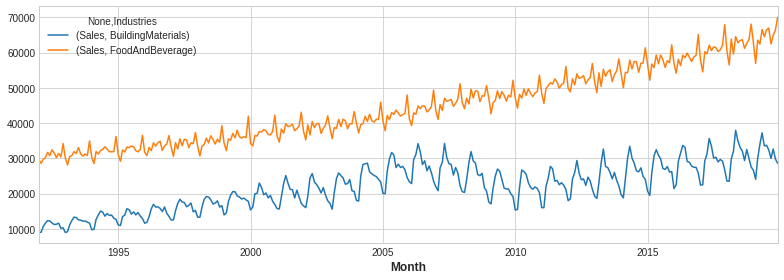

In [4]:
retail.plot()

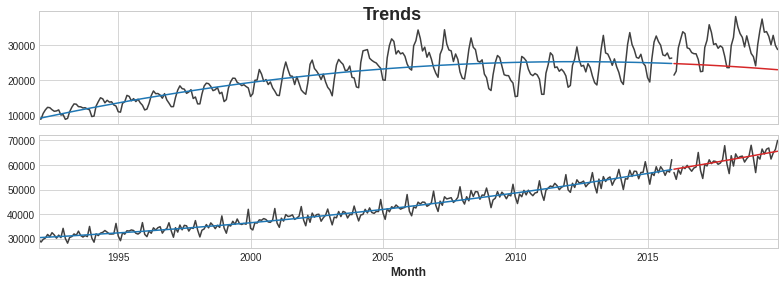

In [6]:
y = retail.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

# Test on the years 2016-2019. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=12 * 4, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [13]:
# The `stack` method converts column labels to row labels, pivoting from wide format to long
X = retail.stack()  # pivot dataset wide to long
display(X.head())
y = X.pop('Sales')  # grab target series

Sales
Month      Industries              
1992-01-01 BuildingMaterials   8964
           FoodAndBeverage    29589
1992-02-01 BuildingMaterials   9023
           FoodAndBeverage    28570
1992-03-01 BuildingMaterials  10608

In [21]:
# Label encoding for 'Industries' feature
X = X.reset_index('Industries')

for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()

# Label encoding for annual seasonality
X["Month"] = X.index.month  # values are 1, 2, ..., 12

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [22]:
display(X)

,Industries,Month
Month,,
1992-01-01,0,1
1992-01-01,1,1
1992-02-01,0,2
1992-02-01,1,2
1992-03-01,0,3
...,...,...
2019-10-01,1,10
2019-11-01,0,11
2019-11-01,1,11


Now we'll convert the trend predictions made earlier to long format and then subtract them from the original series. That will give us detrended (residual) series that XGBoost can learn.

In [23]:
# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

[05:41:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


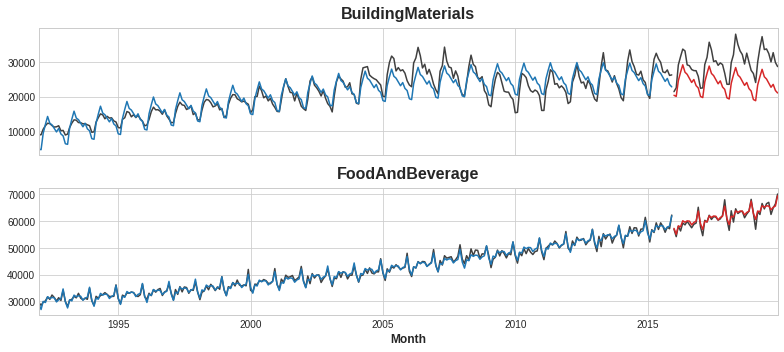

In [24]:
axs = y_train.unstack(['Industries']).plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['BuildingMaterials', 'FoodAndBeverage'],
)
axs = y_test.unstack(['Industries']).plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack(['Industries']).plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack(['Industries']).plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])

In [26]:
y_pred

Month       Industries       
2016-01-01  BuildingMaterials    24669.950487
            FoodAndBeverage      58283.115113
2016-02-01  BuildingMaterials    24645.499575
            FoodAndBeverage      58430.817613
2016-03-01  BuildingMaterials    24620.507554
                                     ...     
2019-10-01  FoodAndBeverage      65277.988422
2019-11-01  BuildingMaterials    22985.159382
            FoodAndBeverage      65441.520959
2019-12-01  BuildingMaterials    22935.817396
            FoodAndBeverage      65605.405275
Name: Sales, Length: 96, dtype: float64

#**Hybrid Class and Methods**

In [31]:
# You'll add fit and predict methods to this minimal class
class BoostedHybrid:
  def __init__(self, model_1, model_2):
      self.model_1 = model_1
      self.model_2 = model_2
      self.y_columns = None  # store column names from fit method
  
def fit(self, X_1, X_2, y):
# YOUR CODE HERE: fit self.model_1
  self.model_1.fit(X_1,y)

  y_fit = pd.DataFrame(
      # YOUR CODE HERE: make predictions with self.model_1
      self.model_1.predict(X_1),
      index=X_1.index, columns=y.columns,
  )

  # YOUR CODE HERE: compute residuals
  y_resid = y-y_fit
  y_resid = y_resid.stack().squeeze() # wide to long

  # YOUR CODE HERE: fit self.model_2 on residuals
  self.model_2.fit(X_2, y_resid)

  # Save column names for predict method
  self.y_columns = y.columns
  # Save data for question checking
  self.y_fit = y_fit
  self.y_resid = y_resid
def predict(self, X_1, X_2):
  y_pred = pd.DataFrame(
      # YOUR CODE HERE: predict with self.model_1
      self.model_1.predict(X_1),
      index=X_1.index, columns=self.y_columns,
  )
  y_pred = y_pred.stack().squeeze()  # wide to long

  # YOUR CODE HERE: add self.model_2 predictions to y_pred
  y_pred += self.model_2.predict(X_2)
  
  return y_pred.unstack()  # long to wide

In [32]:
BoostedHybrid.fit = fit
BoostedHybrid.predict = predict

In [37]:
model = BoostedHybrid(LinearRegression(),XGBRegressor())

In [52]:
y1 = retail.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X1 = dp.in_sample()  # features for the training data

# Test on the years 2016-2019. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=12 * 4, shuffle=False,
)
X_train1, X_test1 = X1.loc[idx_train, :], X1.loc[idx_test, :]
y_train1, y_test1 = y1.loc[idx_train], y1.loc[idx_test]

X2 = retail.stack()  # pivot dataset wide to long
y2 = X2.pop('Sales') 
X2 = X2.reset_index('Industries')
for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()

# Label encoding for annual seasonality
X["Month"] = X.index.month  # values are 1, 2, ..., 12

# Create splits
X_train2, X_test2 = X2.loc[idx_train, :], X2.loc[idx_test, :]
y_train2, y_test2 = y2.loc[idx_train], y2.loc[idx_test]

In [54]:
model.fit(X_train1,X_train2,y_train1)

ValueError: ignored

In [55]:
y_train1.head()

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677